In [1]:
#Pkg.update()
using PyPlot
using TestImages
using ImageFeatures
using Images
using TestImages
using ImageDraw
using ImageDraw 
using Perceptron
using BenchmarkTools

In [2]:
## Param for the notebook
stride = 10

10

### About hog
- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

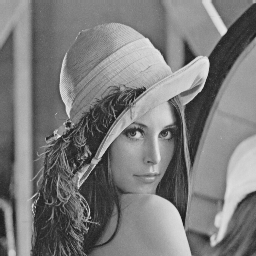

In [3]:
img = testimage("lena_gray")

In [4]:
typeof(img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [5]:
img_as_array = convert(Array{Float32},img);

In [6]:
minimum(img_as_array), maximum(img_as_array)

(0.10196079f0, 0.9490197f0)

## HOG descriptor

- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

In [7]:
#?(HOG)

In [8]:
typeof(img)

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [9]:
h = HOG(orientations=9,
        cell_size=8,
        block_size = 2,
        block_stride = 1,
        norm_method="L2-norm")

ImageFeatures.HOG(9, 8, 2, 1, "L2-norm")

In [10]:
@time hog_features = create_descriptor(img, h);

  6.565391 seconds (7.90 M allocations: 363.719 MiB, 4.80% gc time)


In [11]:
@time hog_features = create_descriptor(img, h);

  0.041348 seconds (1.50 M allocations: 27.985 MiB, 30.98% gc time)


In [12]:
size(img), size(hog_features)

((256, 256), (34596,))

### Load pedestrian data

In [13]:
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)
pos_images = []
neg_images = []

for n in pos_example_names
    push!(pos_images, load( path_positive_examples * n))
end

for n in neg_example_names
    push!(neg_images, load( path_negative_examples * n))
end

In [14]:
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)

n_pos = length(pos_example_names)
n_neg = length(neg_example_names)

n = n_pos + n_neg                       # number of training examples 
data = Array{Float64}(3780, n)          # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector{Int64}(n);              # Vector to store label (1=human, 0=not human) of each image.

for (i, file) in enumerate([pos_example_names ; neg_example_names])
    
    #filename = "$(i <= n_pos ? path_positive_examples : path_negative_examples)/$file"
    if i <= n_pos
        filename =  path_positive_examples * file
    else
        filename = path_negative_examples * file
    end
    
    img = load(filename)   
    if i > n_pos # negative samples are bigger, we take a patch of the same shape
        img = img[1:128, 1:64]
    end
    
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = (i <= n_pos ? 1 : 0)
end

In [15]:
println("size of the data:             ", size(data))
println("size of the labels:           ", size(labels))
println("number of negative labels:    ", sum(labels.==0))
println("number of positive labels:    ", sum(labels.==1))

size of the data:             (3780, 974)
size of the labels:           (974,)
number of negative labels:    50
number of positive labels:    924


## Negative samples are scarse

Notice the number of negative sample is very low, only 50.
We will augment the number of negative samples generating patches from the negative images.

In [16]:
sum(labels .==1), sum(labels.==0)

(924, 50)

In [17]:
size(neg_images[3]), size(pos_images[1])

((256, 256), (128, 64))

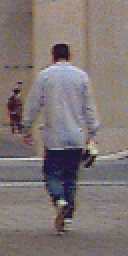

In [18]:
pos_images[1]

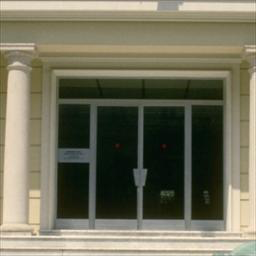

In [19]:
 neg_images[1]

### Generate negative samples of shape (128,64)

In [20]:
function extract_patches_2d(image, patch_size, stride)
    
    n_rows, n_cols = size(image) 
    n_rows_patch, n_cols_patch = patch_size
    patches = []
    for i in 1:stride:(n_rows - n_rows_patch)
        for j in 1:stride:(n_cols - n_cols_patch)
            push!(patches, image[i:i+n_rows_patch-1, j:j+n_cols_patch-1])
        end
    end
    
    return patches
end


extract_patches_2d (generic function with 1 method)

In [21]:
aux = extract_patches_2d(neg_images[1], (128,64), 10);

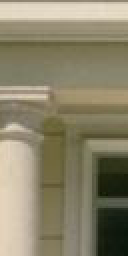

In [22]:
aux[2]

## Putting all the data together

In [23]:
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"

pos_example_names = readdir(path_positive_examples)
n_pos = length(pos_example_names)
n_feat = 3780

data = Array{Float64}(n_feat, n_pos)  # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector{Int64}(n_pos);      # Vector to store label (1=human, 0=not human) of each image.

@time for (i, file) in enumerate(pos_example_names)
    filename =  path_positive_examples * file
    img = load(filename)   
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = 1
end

  4.579838 seconds (93.48 M allocations: 4.217 GiB, 18.70% gc time)


In [24]:
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"
neg_example_names = readdir(path_negative_examples);
size_patch = size(pos_images[1])
hog_descriptor = HOG()
n_neg_samples = length(neg_example_names)
stride_samples = 30
@time begin
    for (i, file) in enumerate(neg_example_names)
        print("Generating negative patches from: $i out of $n_neg_samples  \r")
        
        filename =  path_negative_examples * file
        img = load(filename)   

        # For each negative images we extract several patches
        patches = extract_patches_2d(img, size_patch, stride_samples);

        for patch in patches
            data = hcat(data, create_descriptor(patch, hog_descriptor))
            push!(labels,0);
        end
    end
end

 91.502515 seconds (177.40 M allocations: 96.758 GiB, 23.09% gc time)


In [25]:
size(data), size(labels)

((3780, 2674), (2674,))

In [26]:
println("Number of non pedestrian samples: ", sum(labels.==0))
println("Number of pedestrian samples:     ", sum(labels.==1))

Number of non pedestrian samples: 1750
Number of pedestrian samples:     924


#### Parallelize building features 

- Think about how to do this properly

# Model with Perceptron

#### TODO:
- Missing `tutorial/humans.jpg`


In [27]:
#Pkg.clone("https://github.com/davidbp/Perceptron.jl")

In [28]:
srand(1234)
n_samples = size(data,2)
random_perm = randperm(n_samples)
first_80_percent = Int(round(n_samples*0.8))
train_ind   = random_perm[1:first_80_percent]
test_ind    = random_perm[first_80_percent:end];

img = load("tutorial/humans.jpg")

using Perceptron
n_classes = 2
n_features = 3780
X_train = data[:, train_ind];
y_train = labels[train_ind] .+1;
percep = Perceptron.PerceptronClassifier(Float64, n_classes, n_features)

scores = []
Perceptron.fit!(percep, X_train, y_train, n_epochs=100,  learning_rate=0.1, scores; print_flag=true)

In [29]:
function apply_model_every_patch(model, image, stride, patch_size)
    y_scores = []
    y_hats = []
    positions = Dict()
    k = 0
    n_row_patch, n_col_patch = patch_size
    rows, cols = size(image)
    for j in 1:stride:(cols - n_col_patch)
        for i in 1:stride:(rows - n_row_patch)
            patch = view(image, i:i+n_row_patch-1, j:j+n_col_patch-1)                  
            descriptor      = create_descriptor(patch, HOG())        
            y_hat, y_score  = Perceptron.predict(model, descriptor);
            push!(y_scores, y_score)
            push!(y_hats, y_hat)
            positions[k] = (i,j)
            k = k + 1
        end
    end
    return positions, y_hats, y_scores
end

apply_model_every_patch (generic function with 1 method)

In [30]:
img = load("tutorial/humans.jpg")
patch_size = size(pos_images[1])
positions, y_hats, y_scores = @time apply_model_every_patch(percep, img, stride, patch_size);

  5.286392 seconds (100.24 M allocations: 4.525 GiB, 13.80% gc time)


In [31]:
patch_size, sum(y_hats.==2), stride

((128, 64), 8, 10)

In [32]:
pos = []
for (i,s) in enumerate(y_scores)
    if indmax(s).==2
        push!(pos, i)
    end
end

In [33]:
sum(map(indmax,y_scores).==1), sum(map(indmax,y_scores).==2)

(982, 8)

In [34]:
n_row_patch, n_col_patch = patch_size

(128, 64)

In [35]:
pedestrians_detections = pos
imgres = deepcopy(img)
c = ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}}
for p in pedestrians_detections
    x,y = positions[p]
    imgres[x:x+n_row_patch,y] = c(1,0,0)                  # Left vertical bar
    imgres[x:x+n_row_patch,y+n_col_patch] = c(1,0,0)      # Right vertical bar
    imgres[x,y:y+n_col_patch] = c(1,0,0)                  # Top horizontal bar
    imgres[x+n_row_patch,y:y+n_col_patch] = c(1,0,0)      # Bottom horizontal bar
end

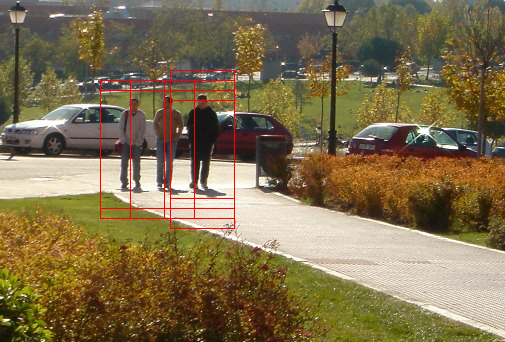

In [36]:
imgres 

## Improving the process with less allocations

We need to make each feature vector faster and generating less allocations.


In [37]:
n_row_patch, n_col_patch = patch_size
i,j = 1,1
patch = view(img, i:i+n_row_patch-1, j:j+n_col_patch-1)
patch = @time zeros(create_descriptor(patch, HOG()));

  0.007530 seconds (102.25 k allocations: 4.757 MiB)


In [38]:
function apply_model_every_patch2(model, image, stride, patch_size)
    y_scores = []
    y_hats = []
    positions = Dict()
    local y_hat::Int = 0
    local y_score = [0,0]
    
    k = 0
    n_row_patch, n_col_patch = patch_size
    rows, cols = size(image)
    patch = view(image, i:i+n_row_patch-1, j:j+n_col_patch-1)                  
    
    for j in 1:stride:(cols - n_col_patch)
        for i in 1:stride:(rows - n_row_patch)
            patch = view(image, i:i+n_row_patch-1, j:j+n_col_patch-1)                  
            descriptor      = create_descriptor(patch, HOG())        
            y_hat, y_score  = Perceptron.predict(model, descriptor);
            push!(y_scores, y_score)
            push!(y_hats, y_hat)
            positions[k] = (i,j)
            k = k + 1
        end
    end
    
    return positions, y_hats, y_scores
end

apply_model_every_patch2 (generic function with 1 method)

In [39]:
img = load("tutorial/humans.jpg")
patch_size = size(pos_images[1])
@time apply_model_every_patch2(percep,img, stride, patch_size);

  4.907517 seconds (100.04 M allocations: 4.516 GiB, 16.24% gc time)


In [40]:
img = load("tutorial/humans.jpg")
patch_size = size(pos_images[1])
@time apply_model_every_patch(percep, img, stride, patch_size);

  4.935238 seconds (100.02 M allocations: 4.515 GiB, 17.63% gc time)


In [41]:
@time for i in 1:900 
    aux = create_descriptor( view(img, 1:1+n_row_patch-1, 1:1+n_col_patch-1), HOG()); 
end

  4.427581 seconds (91.16 M allocations: 4.108 GiB, 17.07% gc time)


### Apply at every patch with `mapwindow`

In [62]:
length(positions), size(img), patch_size

(990, (342, 505), (128, 64))